# **SEBAL Analysis of Daily ETa Rasters**

In [40]:

# Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.stats import variation,zscore
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.merge import merge
from rioxarray.merge import merge_arrays
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import random
import seaborn as sns
import itertools

# Loading geocube to raterize vector polygons (https://github.com/corteva/geocube)
from geocube.api.core import make_geocube

import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib
#import geowombat




import glob
import os
import os.path
import sys

ModuleNotFoundError: No module named 'gdal'

In [2]:
# Import SPAEF Function from https://github.com/cuneyd/spaef
import SPAEF_metric as sp

In [3]:
# import required modules
import numpy as np
from scipy.stats import variation,zscore
import math
######################################################################################################################
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[~np.isnan(data).any(1)]
    return data[:,0], data[:,1]
######################################################################################################################
def SPAEF(s, o):
    #remove NANs    
    s,o = filter_nan(s,o)
    
    bins_float=np.around(math.sqrt(len(o)),0)
    bins=int(bins_float)
    #compute corr coeff
    alpha = np.corrcoef(s,o)[0,1]
    #compute ratio of CV
    beta = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    gamma = np.sum(minima)/np.sum(hobs)
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (alpha-1)**2 + (beta-1)**2 + (gamma-1)**2 )  

    return spaef, alpha, beta, gamma
######################################################################################################################

In [4]:
# Insert Start of data directory 
# path_data = "../../DATA_MesoHyd_MA-SEBAL/"   # Path data SC_UL
path_data = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/" # Path data NICOLAS-PC



In [5]:
# Set date(s) of modelling/data retrieval
# date = "2015-07-04"  # Initial LS Picture
date = "2017-04-20"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)


# Date in meteo_raster_daily Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)


# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_").replace("_", "_")
print("Date WASIM =", date_wasim)


# Date in ETp-FAO56-Raster Path Format
date_etp = date.date()
date_etp = date_etp.strftime('%Y_%m_%d').replace("_0", "-").replace("_", "-")
print("Date ETp =", date_etp)


# Date SSEB Format
date_SSEB = date.date()
date_SSEB = date_SSEB.strftime('%Y_%m_%d').replace("-", "_")
print("Date SSEB =", date_SSEB)

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)


Date normal = 2017-04-20 00:00:00
Date INTERMET = 2017-04-20
Date WASIM = 2017_4_20
Date ETp = 2017-4-20
Date SSEB = 2017_04_20
Date Landsat = 20170420


# Import Data

### Import Catchment Shapes

In [6]:
# 0. Path for GeoTIFF
stack_name = "LS08_" + date_LS + ".tif"
stack_path = path_data + "Processed/LANDSAT/LS_Processed/" + stack_name

# Load Shapefile for Catchments
path_shapeA = path_data + "Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = path_data + "Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

### Import SEBAL ETa Map

In [7]:
# Export ETa_day Raster 
export_path = path_data + "Processed/export/eta_day/ETa_day_" + date_SSEB + ".tif"


In [8]:
eta_day = rxr.open_rasterio(export_path, masked = True).squeeze()

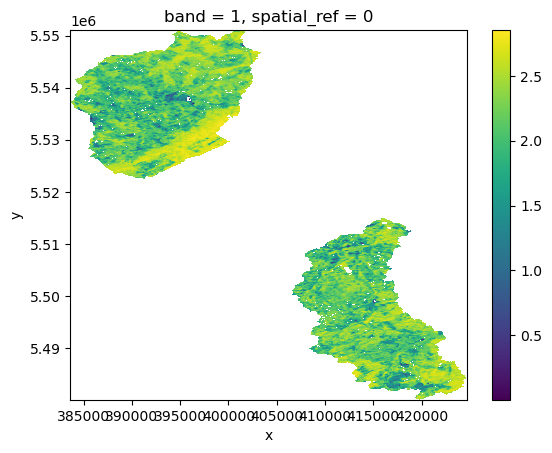

In [9]:
eta_day.plot()

### Import CORINE Land Cover Map

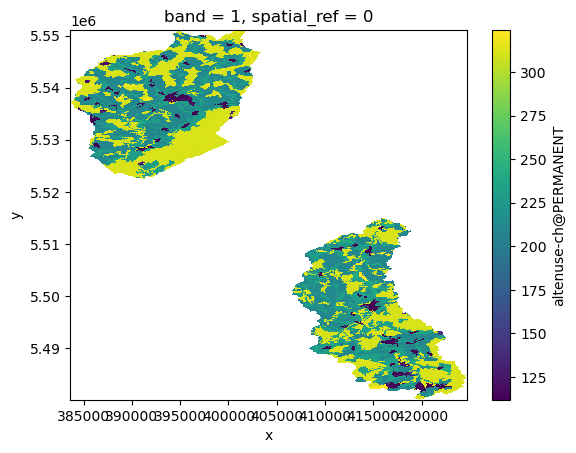

In [10]:
# Open Corine Land Use Maps for both catchments
path_LUA = path_data + "Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = path_data + "Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()

# Merge raster
LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
LU_mosaic.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = LU_mosaic
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

LU_mosaic = xds_repr_match

LU_mosaic.plot()


In [11]:
print(np.unique(LU_mosaic))
print(len(np.unique(LU_mosaic)))

[112. 121. 131. 132. 142. 211. 221. 231. 242. 243. 311. 312. 313. 322.
 324.  nan]
16


In [12]:
# Combine with Land Cover Key Table
LU_table_path = "../../data/clc_legend.csv"
LU_table = pd.read_csv(LU_table_path) #delimiter = "\t", header = [3]
#print(LU_table)

LU_agri = [211, 212, 221, 222, 223, 241, 242, 243, 244]
LU_bare = [331, 332, 333, 334, 131]
LU_grass = [231, 321, 322, 323, 324, 411, 412]
LU_urban = [111, 112, 121, 122, 123, 124, 132, 133, 141, 142]
LU_forest = [311, 312, 313]
LU_water = [511, 512, 335]

# Create filters from Land Use classes
agri_filter = np.isin(LU_mosaic.values, LU_agri)
bare_filter = np.isin(LU_mosaic.values, LU_bare)
grass_filter = np.isin(LU_mosaic.values, LU_grass)
urban_filter = np.isin(LU_mosaic.values, LU_urban)
forest_filter = np.isin(LU_mosaic.values, LU_forest)
water_filter = np.isin(LU_mosaic.values, LU_water)

### Results Lists

In [13]:
# Full regression
WASIM_fullreg = []
SSEB_fullreg = []
EEFlux_fullreg = []

# Agri
WASIM_agri = []
SSEB_agri = []
EEFlux_agri = []

# Bare Soil
WASIM_bare = []
SSEB_bare = []
EEFlux_bare = []

# Grass
WASIM_grass = []
SSEB_grass = []
EEFlux_grass = []

# Urban
WASIM_urban = []
SSEB_urban = []
EEFlux_urban = []

# Forest
WASIM_forest = []
SSEB_forest = []
EEFlux_forest = []

# WASIM ETa Raster

### Load data

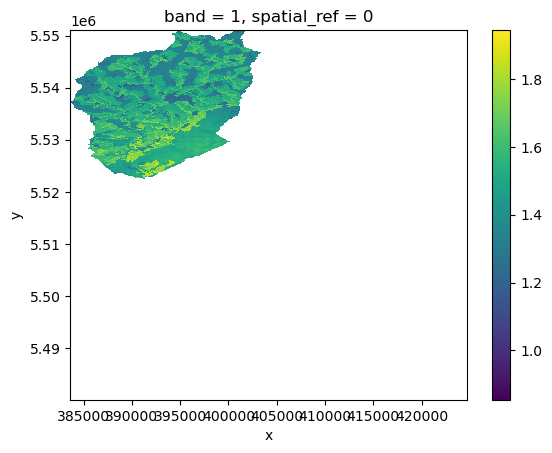

In [14]:
# Open WASIM Raster
path_wasim_kelle = path_data + "Original/WASIM_raster/etr_kelle_" + date_SSEB + ".tif"
wasim_kelle = rxr.open_rasterio(path_wasim_kelle, masked = True).squeeze()

# Merge raster
#LU_mosaic = merge_arrays(dataarrays = [LU_alten, LU_kellen], nodata = np.nan)
#LU_mosaic = LU_mosaic .rename({"x": "long", "y": "lat"})
wasim = wasim_kelle # + merged wasim altenbamberg
wasim.rio.write_crs("epsg:32632", inplace=True)

# Reproject and Resample Land Use Raster

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = wasim
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

wasim = xds_repr_match

wasim.plot()

### Scatterplot, simple statistics

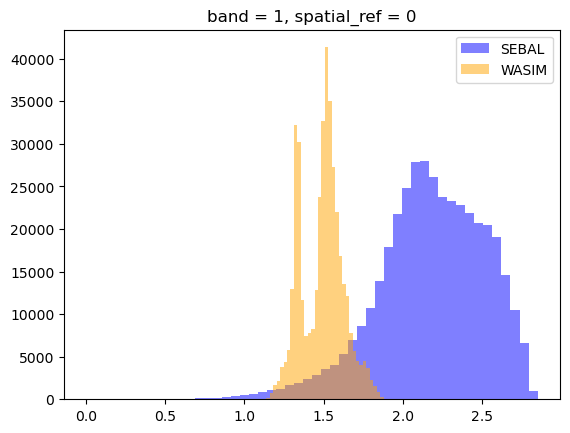

In [15]:
eta_kelle = eta_day.rio.clip(shape_kellen.geometry, all_touched = True)

eta_kelle.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
wasim.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "WASIM")
plt.legend(loc='upper right')
plt.show()

Slope: -0.07396275205665587
Intercept: 1.6528945321974335
R-squared value: 0.03733365076222044
P-value: 0.0
Standard error: 0.000595055419234283


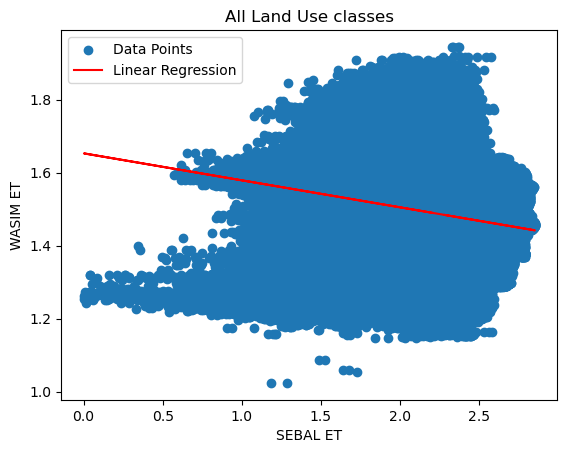

In [16]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Append results to list
WASIM_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))



### Statistics grouped by Land Use

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

Slope: -0.01332840909681829
Intercept: 1.5595305120380902
R-squared value: 0.003955469336655829
P-value: 2.404775492319914e-123
Standard error: 0.0005637262434540032


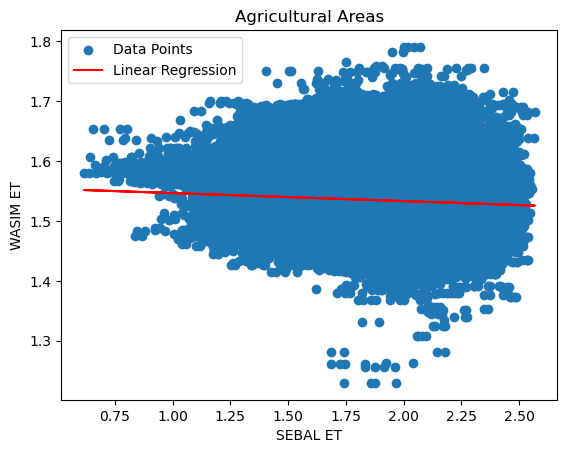

In [17]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(agri_filter).values
y_values = wasim.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.07752192730546942
Intercept: 1.7992011611172523
R-squared value: 0.01922575945848328
P-value: 0.0
Standard error: 0.0019820992625262106


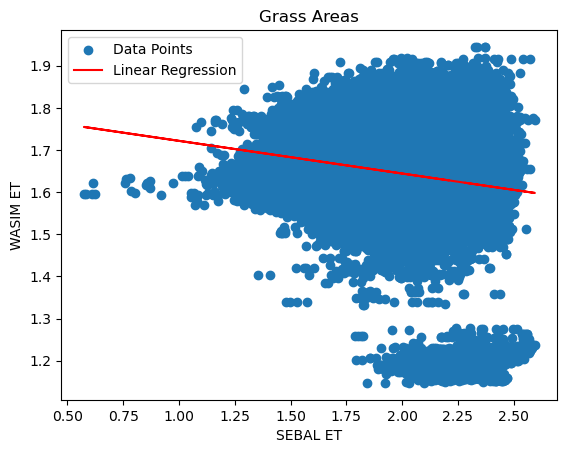

In [18]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(grass_filter).values
y_values = wasim.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.12897096294455673
Intercept: 1.0898119454394823
R-squared value: 0.09225037065785448
P-value: 0.0
Standard error: 0.0010022461608386246


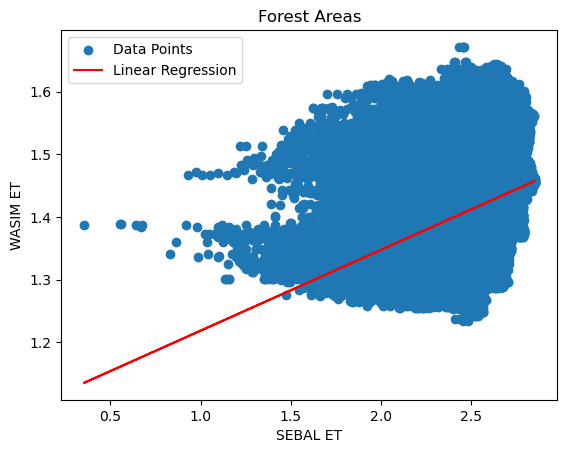

In [19]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(forest_filter).values
y_values = wasim.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.12400190569280378
Intercept: 1.6121906574149454
R-squared value: 0.3252491705640788
P-value: 1.8528530647682657e-55
Standard error: 0.0071384645583860516


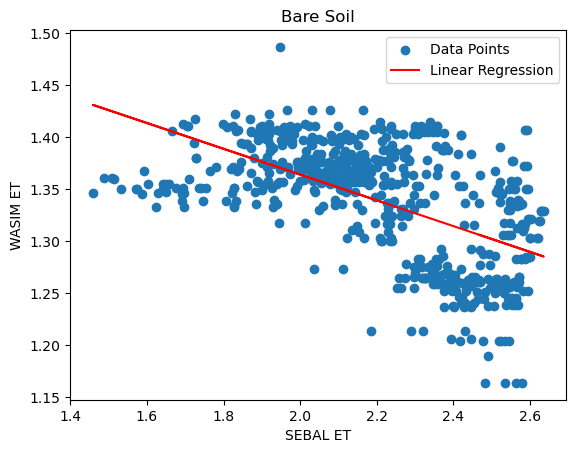

In [20]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(bare_filter).values
y_values = wasim.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.006830475753501467
Intercept: 1.268969366576193
R-squared value: 0.00184477704191953
P-value: 5.5062309662935454e-08
Standard error: 0.00125635706004997


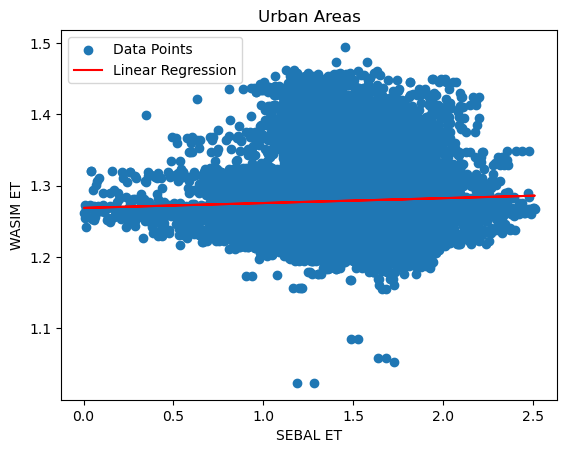

In [21]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "WASIM ET"

x_values = eta_day.where(urban_filter).values
y_values = wasim.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results to list
WASIM_urban.extend((slope, intercept, r_value**2, p_value, std_err))

### SPAEF WASIM

In [22]:
SPAEF(wasim.values, eta_day.values)

(-0.4551663963640906,
 -0.19321917803939762,
 0.5588875983725238,
 0.29348950227425624)

# SSEB Raster

### Load data

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\SSEB_ETa_Landsat-8_alten_2017_04_20_50m.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/SSEB\\SSEB_ETa_Landsat-8_kelle_2017_04_20_50m.tif']


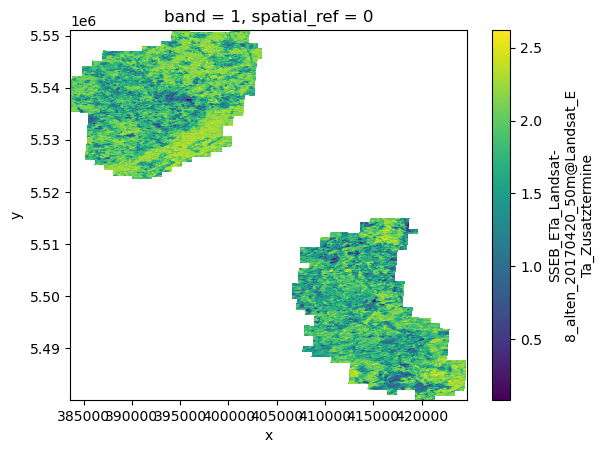

In [23]:
# DATA FROM SSEB

# Date in SSEB-Raster Path Format with time (hour)

# Create Path for recursive file search based on defined date
path_SSEB = path_data + "Original/SSEB/"
pattern = f"*{date_SSEB}*.tif"
paths_SSEB = sorted(glob.glob(os.path.join(path_SSEB, "**", pattern), recursive=True))
print(paths_SSEB)

# Combine both Rasters
raster_0 = rxr.open_rasterio(paths_SSEB[0]).squeeze()
raster_1 = rxr.open_rasterio(paths_SSEB[1]).squeeze()
SSEB_raster = merge_arrays(dataarrays = [raster_0, raster_1], nodata = np.nan)
SSEB_raster.rio.write_crs("epsg:32632", inplace=True)

# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = SSEB_raster
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

SSEB_raster = xds_repr_match

SSEB_raster.plot()

### Scatterplot, simple statistics

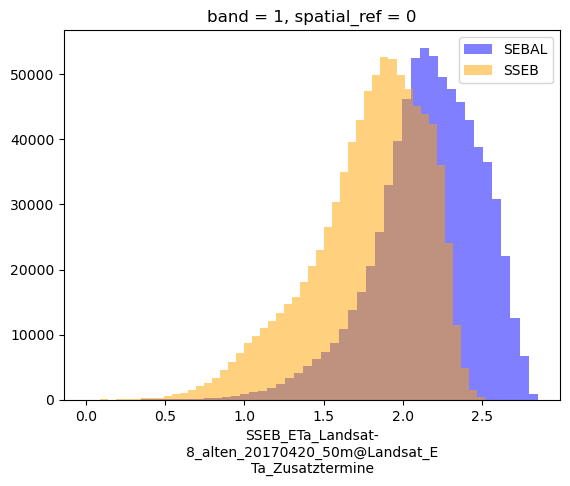

In [24]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
SSEB_raster.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "SSEB")
plt.legend(loc='upper right')
plt.show()

Slope: 0.9727757685517108
Intercept: -0.321901548486782
R-squared value: 0.8084154315609685
P-value: 0.0
Standard error: 0.0005483742326640325


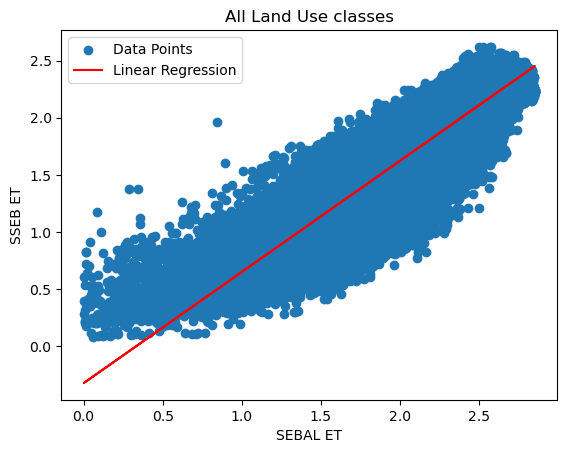

In [25]:
### Define Datasets 
title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.values
y_values = SSEB_raster.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

# Results into List
SSEB_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.1737017159421994
Intercept: -0.7325927932482459
R-squared value: 0.7132485729396855
P-value: 0.0
Standard error: 0.0014634062369357121


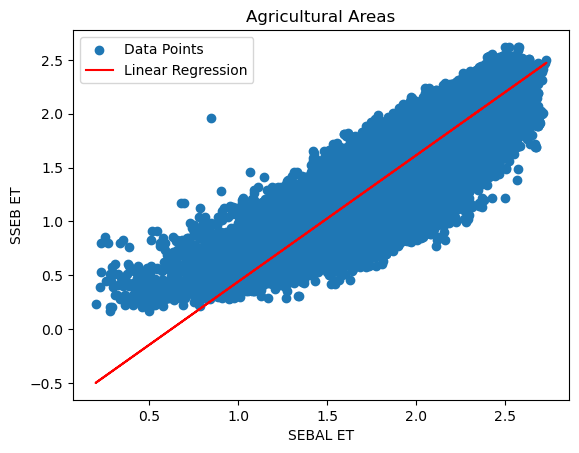

In [26]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(agri_filter).values
y_values = SSEB_raster.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.9478687513564418
Intercept: -0.27437969171323306
R-squared value: 0.676834983252625
P-value: 0.0
Standard error: 0.0015828433165394622


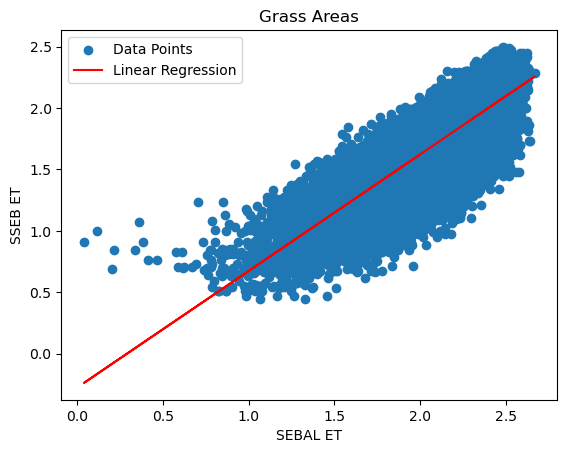

In [27]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(grass_filter).values
y_values = SSEB_raster.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.8135441419474012
Intercept: 0.06578763488364547
R-squared value: 0.7473110065221288
P-value: 0.0
Standard error: 0.0008933575213359786


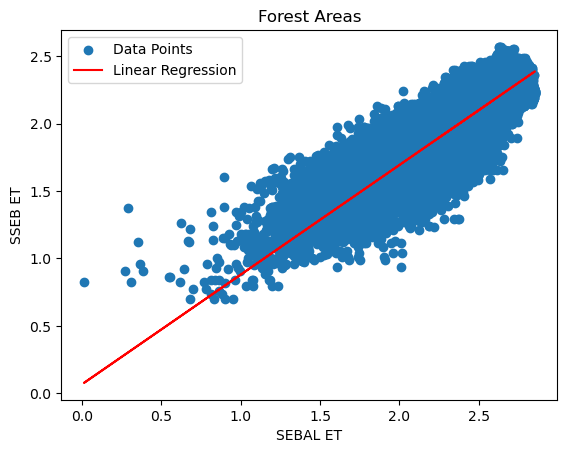

In [28]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(forest_filter).values
y_values = SSEB_raster.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.8247994462738513
Intercept: -0.27711083622786514
R-squared value: 0.7671722684250271
P-value: 2.771319723955456e-200
Standard error: 0.018160679736739748


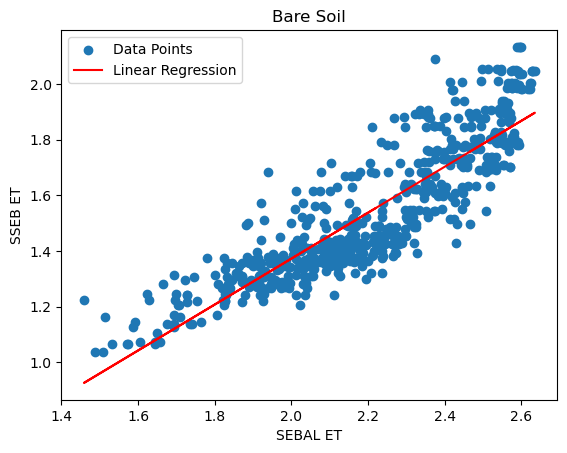

In [29]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(bare_filter).values
y_values = SSEB_raster.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 0.6826250880020703
Intercept: 0.13722236675641408
R-squared value: 0.7349368029268889
P-value: 0.0
Standard error: 0.00219520384876887


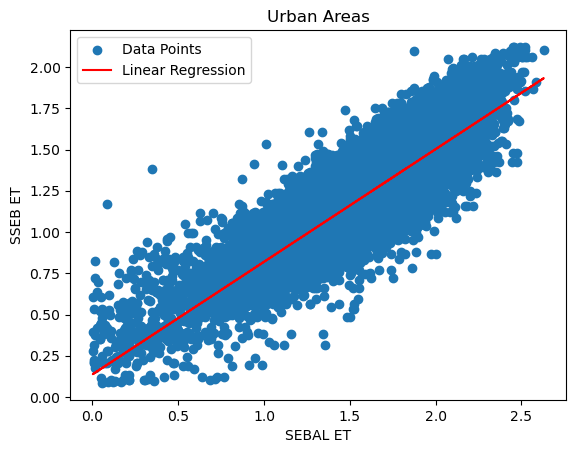

In [30]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "SSEB ET"

x_values = eta_day.where(urban_filter).values
y_values = SSEB_raster.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
SSEB_urban.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: -0.04619636324128609
Intercept: 1.5768951447317336
R-squared value: 0.015411856825105196
P-value: 0.0
Standard error: 0.0005825829504726872


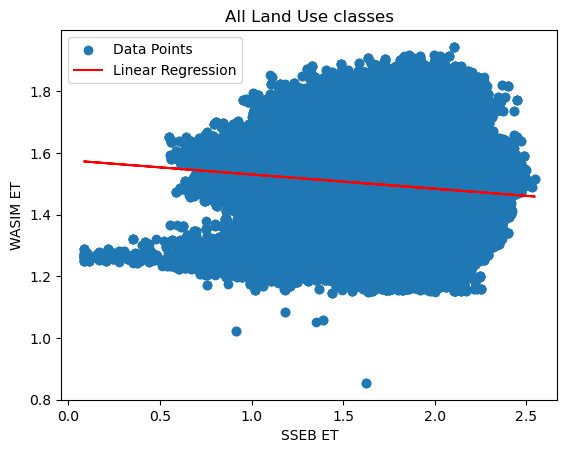

In [31]:
# WASIM AND SSEB
### Define Datasets 
title = "All Land Use classes"
x_name = "SSEB ET"
y_name = "WASIM ET"

x_values = SSEB_raster.values
y_values = wasim.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()


# Show the plot
plt.show()

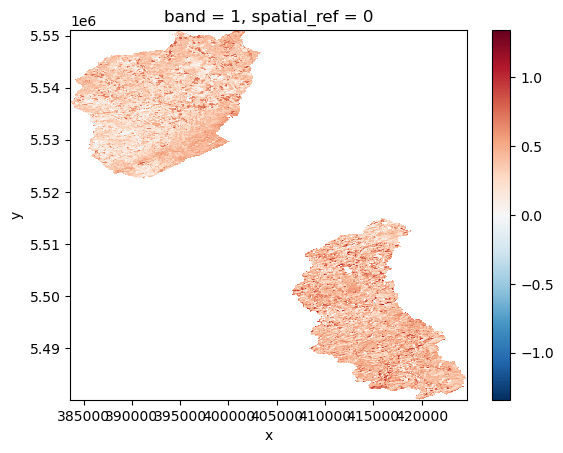

In [32]:
# Difference raster
diff = eta_day - SSEB_raster
diff.plot()

### SPAEF SSEB

In [33]:
SPAEF(eta_day.values, SSEB_raster.values)

(0.637257460545458, 0.8991192532478484, 0.761291627446483, 0.746182077588068)

In [34]:
SPAEF(SSEB_raster.values, eta_day.values)

(0.58416529809453, 0.8991192532478484, 1.3135570705725352, 0.746182077588068)

# EEFlux Raster

### Load data

In [39]:
# DATA FROM EEFlux

# Date in EEflux-Raster Path Format with time (hour)
date_eeflux = date_SSEB

# Create Path for recursive file search based on defined date
path_dir = path_data + "Original/EEFlux/"
pattern = f"*{date_eeflux}*.tif"
path_eeflux = sorted(glob.glob(os.path.join(path_dir, "**", pattern), recursive=True))
print(path_eeflux)

# Combine both Rasters
eeflux = rxr.open_rasterio(path_eeflux[0]).squeeze()
eeflux .rio.write_crs("epsg:32632", inplace=True)

# Clip raster by catchment vectors
eeflux_clip = eeflux.rio.clip(shape_catchments.geometry, all_touched = True)

# Resample rad raster big to same resolution (30x30m)
# Using reproject_match https://corteva.github.io/rioxarray/html/examples/reproject_match.html
xds_match = eta_day
xds = eeflux_clip
xds_repr_match = xds.rio.reproject_match(xds_match)

xds_repr_match = xds_repr_match.assign_coords({
    "x": xds_match.x,
    "y": xds_match.y,
})

eeflux = xds_repr_match

['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux\\eeflux_2017_04_20.tif']


RasterioIOError: Read or write failed. D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux/eeflux_2017_04_20.tif, band 1: IReadBlock failed at X offset 9, Y offset 23: TIFFReadEncodedTile() failed.

In [38]:
eeflux.plot()

RasterioIOError: Read or write failed. D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/EEFlux/eeflux_2017_04_20.tif, band 1: IReadBlock failed at X offset 9, Y offset 23: TIFFReadEncodedTile() failed.

### Scatterplot, simple statistics

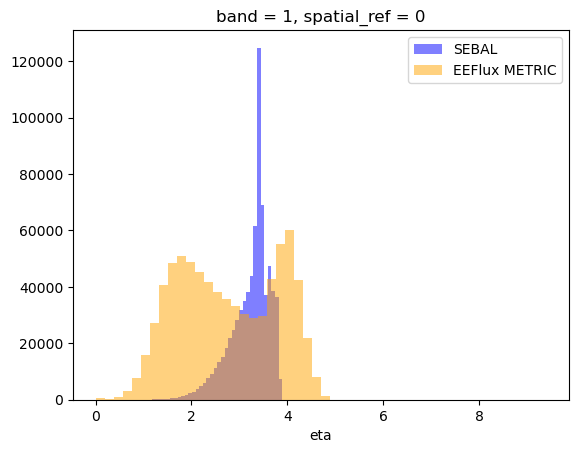

In [ ]:
eta_day.plot.hist(bins = 50, alpha = 0.5, color = "blue", label = "SEBAL")
eeflux.plot.hist(bins = 50, alpha = 0.5, color = "orange", label = "EEFlux METRIC")
plt.legend(loc='upper right')
plt.show()

Slope: 2.0173960886433373
Intercept: -3.76006905322415
R-squared value: 0.6295252469848827
P-value: 0.0
Standard error: 0.0017912130954120449


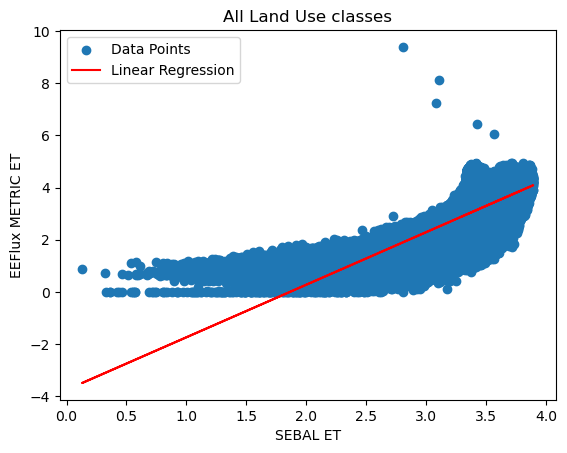

In [ ]:
### Define Datasets 

title = "All Land Use classes"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.values
y_values = eeflux.values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results in List
EEFlux_fullreg.extend((slope, intercept, r_value**2, p_value, std_err))


Slope: 1.1762793274798966
Intercept: -1.4548001511613493
R-squared value: 0.6324709286911253
P-value: 0.0
Standard error: 0.0017592422642240646


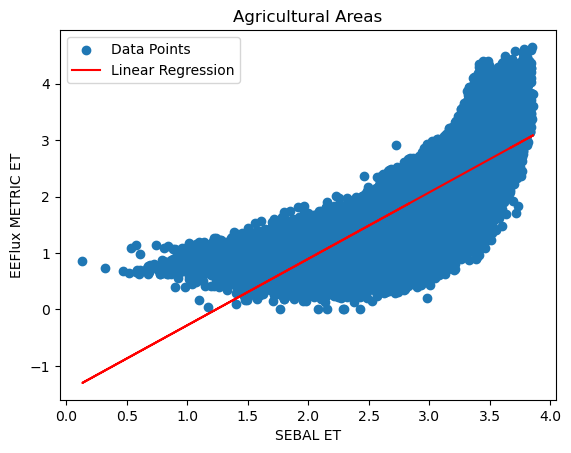

In [ ]:
### Define Datasets 
title = "Agricultural Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(agri_filter).values
y_values = eeflux.where(agri_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_agri.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.9353368488540525
Intercept: -3.8607484344195555
R-squared value: 0.5615919594988281
P-value: 0.0
Standard error: 0.004129971308634711


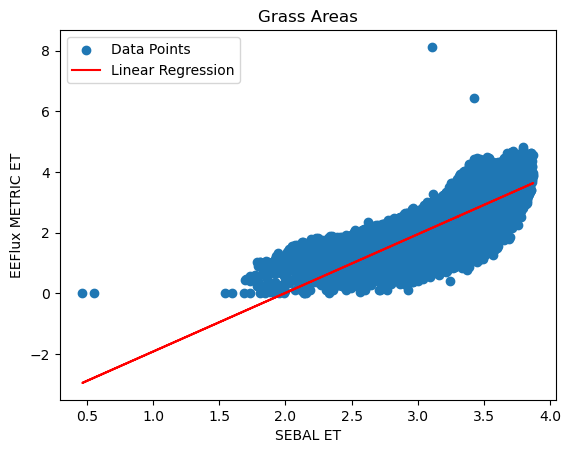

In [ ]:
### Define Datasets 
title = "Grass Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(grass_filter).values
y_values = eeflux.where(grass_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_grass.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.535257147744274
Intercept: -1.6119890323327484
R-squared value: 0.22279848919309464
P-value: 0.0
Standard error: 0.005414957802514728


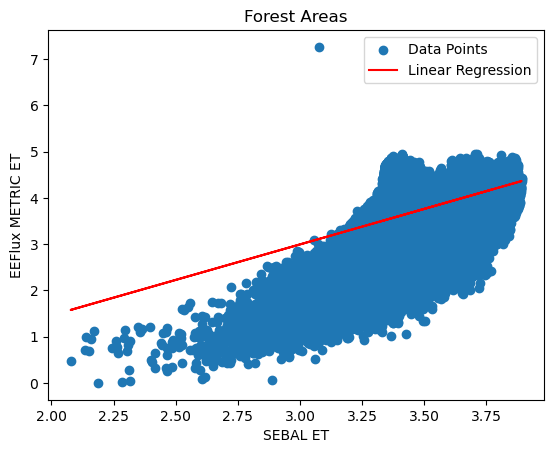

In [ ]:
### Define Datasets 
title = "Forest Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(forest_filter).values
y_values = eeflux.where(forest_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_forest.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 2.917252413848372
Intercept: -7.35248881472808
R-squared value: 0.5259021709443616
P-value: 2.378583462076309e-65
Standard error: 0.14007709634543186


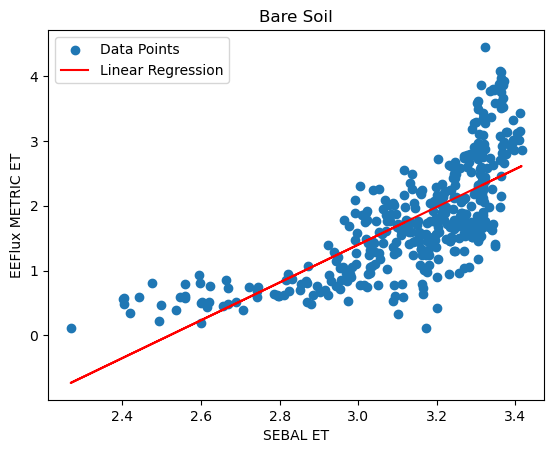

In [ ]:
### Define Datasets 
title = "Bare Soil"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(bare_filter).values
y_values = eeflux.where(bare_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_bare.extend((slope, intercept, r_value**2, p_value, std_err))

Slope: 1.510374555338408
Intercept: -2.9670433876648223
R-squared value: 0.5403081056275897
P-value: 0.0
Standard error: 0.007502415600681154


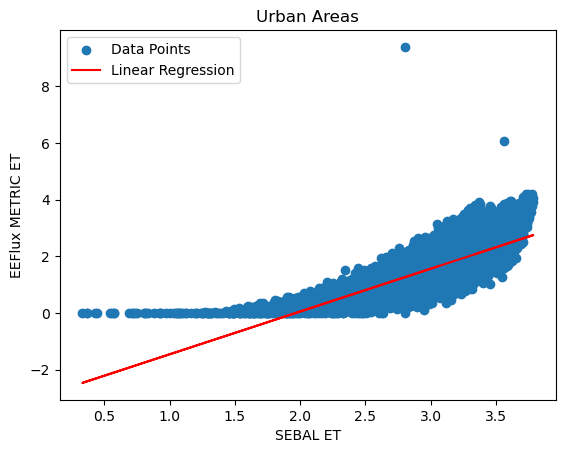

In [ ]:
### Define Datasets 
title = "Urban Areas"
x_name = "SEBAL ET"
y_name = "EEFlux METRIC ET"

x_values = eta_day.where(urban_filter).values
y_values = eeflux.where(urban_filter).values

# Remove NaN values
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]



### Linear Regression and Coefficients 
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared value: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")


### Plot Regression
plt.scatter(x_values, y_values, label='Data Points')

# Plot the regression line
regression_line = slope * x_values + intercept
plt.plot(x_values, regression_line, color='red', label='Linear Regression')

# Labeling the plot
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(title)
plt.legend()

# Show the plot
plt.show()

# Results into List
EEFlux_urban.extend((slope, intercept, r_value**2, p_value, std_err))

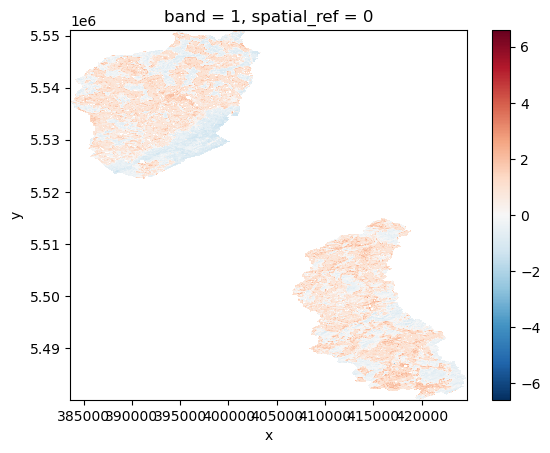

In [ ]:
# Difference raster
diff = eta_day - eeflux
diff.plot()

### SPAEF EEFlux

In [ ]:
SPAEF(eeflux.values, eta_day.values)

(-1.2200039199293582,
 0.7934262706672135,
 2.977521218223453,
 0.012500870720742444)

In [ ]:
SPAEF(eta_day.values, eeflux.values)

(-0.20785871774854559,
 0.7934262706672135,
 0.3358498316920989,
 0.012500870720742444)

# Regression Table

In [ ]:
land_use_reg = [WASIM_agri, SSEB_agri, EEFlux_agri, 
                WASIM_bare, SSEB_bare, EEFlux_bare, 
                WASIM_grass, SSEB_grass, EEFlux_grass,
                WASIM_urban, SSEB_urban, EEFlux_urban,
                WASIM_forest, SSEB_forest, EEFlux_forest 
                ]



In [ ]:
land_use_names = ["WASIM_agri", "SSEB_agri", "EEFlux_agri", 
                "WASIM_bare", "SSEB_bare", "EEFlux_bare", 
                "WASIM_grass", "SSEB_grass", "EEFlux_grass",
                "WASIM_urban", "SSEB_urban", "EEFlux_urban",
                "WASIM_forest", "SSEB_forest", "EEFlux_forest" 
                ]

modelnames = ["WASIM", "SSEB", "EEFlux"] * 5

land_use_class = ["Agriculture"]*3+["BareSoil"]*3+["Grass"]*3+["Urban"]*3+["Forest"]*3

In [ ]:
parameters = ["slope", "intercept", "r_sqrd", "p_value", "std_err"]

full_regressions = pd.DataFrame({
    "Parameter": parameters,
    "WASIM": WASIM_fullreg,
    "SSEB": SSEB_fullreg})

full_regressions

,Parameter,WASIM,SSEB
0,slope,0.935469,1.807679
1,intercept,0.261303,-3.504850
2,r_sqrd,0.428548,0.663096
3,p_value,0.000000,0.000000
4,std_err,0.001716,0.001491


In [ ]:
colnames = ["Model", "LandUse", "slope", "intercept", "r_sqrd", "p_value", "std_err"]

df = pd.DataFrame(columns=colnames)

list = []

for i in range(0,len(land_use_class)):
    list = [modelnames[i]]
    list.append(land_use_class[i])
    list.extend(land_use_reg[i])
    df.loc[i] = list
    
df

,Model,LandUse,slope,intercept,r_sqrd,p_value,std_err
0,WASIM,Agriculture,0.015013,2.567334,0.001385,5.888428e-44,0.001079
1,SSEB,Agriculture,1.106496,-1.709325,0.696453,0.000000e+00,0.001433
2,EEFlux,Agriculture,1.176279,-1.454800,0.632471,0.000000e+00,0.001759
3,WASIM,BareSoil,0.128834,2.189249,0.058052,1.347482e-06,0.026245
4,SSEB,BareSoil,1.701845,-3.405770,0.616842,1.820568e-83,0.067832
5,EEFlux,BareSoil,2.917252,-7.352489,0.525902,2.378583e-65,0.140077
6,WASIM,Grass,0.060323,3.059322,0.002307,6.372166e-41,0.004500
7,SSEB,Grass,1.487977,-2.656236,0.529702,0.000000e+00,0.003386
8,EEFlux,Grass,1.935337,-3.860748,0.561592,0.000000e+00,0.004130
9,WASIM,Urban,-0.028950,2.198555,0.004149,4.543713e-16,0.003560


<Axes: xlabel='LandUse', ylabel='r_sqrd'>

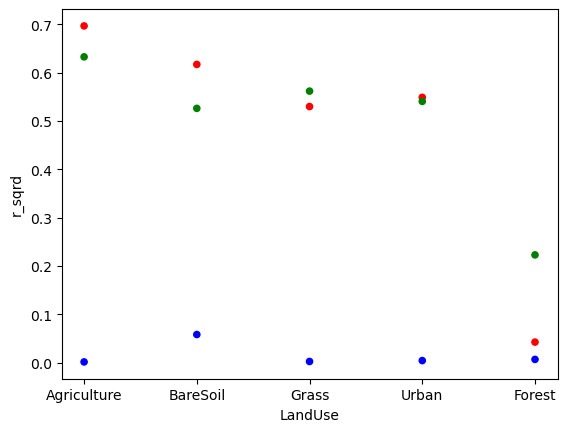

In [ ]:
colors = {"WASIM":"blue",
          "SSEB": "red", 
          "EEFlux": "green"}
df.plot.scatter(x = "LandUse", y = "r_sqrd", c = df["Model"].map(colors))

### Correlation Matrix

In [ ]:
# Correlation Matrix
ds = xr.Dataset({"SEBAL": eta_day, "WASIM": wasim, 
                     "SSEB": SSEB_raster, "EEFlux": eeflux})

correlation_matrix = ds.to_dataframe().corr()
correlation_matrix = correlation_matrix.iloc[2:6,2:6]
#xr.corr(eta_day, wasim)
correlation_matrix

,SEBAL,WASIM,SSEB,EEFlux
SEBAL,1.000000,0.654636,0.814307,0.793426
WASIM,0.654636,1.000000,0.763464,0.707153
SSEB,0.814307,0.763464,1.000000,0.921053
EEFlux,0.793426,0.707153,0.921053,1.000000


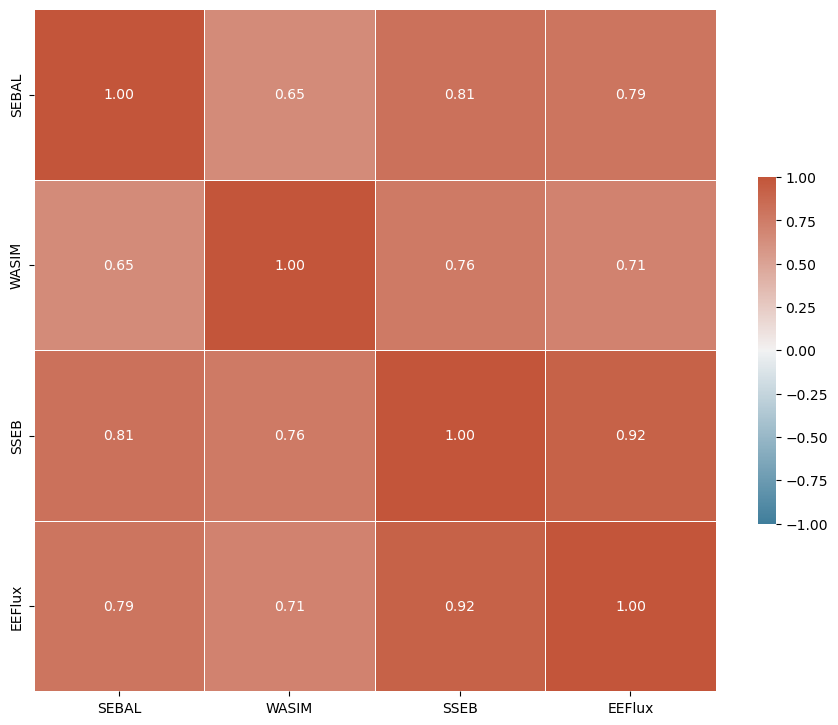

In [ ]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the full correlation matrix heatmap with annotations
sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

# Show the plot
plt.show()